# Приоритезация гипотез для увеличения выручки
# Анализ результатов A/B-теста для крупного интернет магазина

**Задача проекта** на основании предоставленных данных:

* **Файл /datasets/hypothesis.csv**
* Hypothesis — краткое описание гипотезы
* Reach — охват пользователей по 10-балльной шкале
* Impact — влияние на пользователей по 10-балльной шкале
* Confidence — уверенность в гипотезе по 10-балльной шкале
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы

* **Файл /datasets/orders.csv**
* transactionId — идентификатор заказа
* visitorId — идентификатор пользователя, совершившего заказ
* date — дата, когда был совершён заказ
* revenue — выручка заказа
* group — группа A/B-теста, в которую попал заказ

* **Файл /datasets/visitors.csv**
* date — дата
* group — группа A/B-теста
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

**Провести** ПРИОРИТЕЗАЦИЮ ГИПОТЕЗ.

**Проанализировать** РЕЗУЛЬТАТЫ А/В ТЕСТА.

**Принять** РЕШЕНИЕ ПО РЕЗУЛЬТАТАМ А/В ТЕСТА:
1. Остановить тест, зафиксировать победу одной из групп
2. Остановить тест, зафиксировать отсутствие различий между группами
3. Продолжить тест

## Загрузка и подготовка данных к анализу

Путь к файлам:
* /datasets/hypothesis.csv

* /datasets/orders.csv

* /datasets/visitors.csv

### Загрузка данных

In [1]:
# импортируем библиотеки, подготавливаем рабочую среду

import pandas as pd
from scipy import stats as st
from scipy.stats import ttest_ind
import numpy as np
import math as mth
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 110)

In [2]:
# загружаем данные,
# выводим данные и информацию о данных

hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

display(hypothesis)
print() 
display(orders.info(), orders.head(5))
print()
display(visitors.info(), visitors)


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


### Проверка и преобразование данных

In [3]:
# приводим названия колонок в таблице hypothesis к нижнему регистру

hypothesis.columns = map(str.lower, hypothesis.columns)
display(hypothesis.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [4]:
# проверяем наличие дубликатов в таблицах orders и visitors

print('Кол-во дубликатов в таблице orders:', orders.duplicated().sum())
print()
print('Кол-во дубликатов в таблице visitors:', visitors.duplicated().sum())

Кол-во дубликатов в таблице orders: 0

Кол-во дубликатов в таблице visitors: 0


In [5]:
# приводим данные в колонках date в таблицах
# orders и visitors к формату datetime

orders['date'] = orders['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
display(orders.dtypes, visitors.dtypes)

transactionId             int64
visitorId                 int64
date             datetime64[ns]
revenue                   int64
group                    object
dtype: object

date        datetime64[ns]
group               object
visitors             int64
dtype: object

In [6]:
# проверяем минимальные и максимальные значения колонок date в таблицах orders и visitors

print('Таблица orders - мин дата: {}, макс дата: {}'.format(orders['date'].min(), orders['date'].max()))
print()
print('Таблица visitors - мин дата: {}, макс дата: {}'.format(visitors['date'].min(), visitors['date'].max()))

Таблица orders - мин дата: 2019-08-01 00:00:00, макс дата: 2019-08-31 00:00:00

Таблица visitors - мин дата: 2019-08-01 00:00:00, макс дата: 2019-08-31 00:00:00


### Анализ распределение пользователей по группам

In [7]:
# строим сводную таблицу с распределением заказаов
# по каждому уникальному id пользователя между группами теста

orders_split = orders.pivot_table(index = 'visitorId', columns = 'group', values = 'transactionId', aggfunc = ('count')).reset_index()
orders_split = orders_split.fillna(0)
display(orders_split.sort_values(by='B', ascending=False).head(10))


group,visitorId,A,B
591,2458001652,5.0,6.0
569,2378935119,4.0,5.0
897,3717692402,1.0,4.0
917,3803269165,1.0,4.0
744,3062433592,1.0,4.0
1023,4256040402,7.0,4.0
619,2587333274,1.0,3.0
667,2742574263,0.0,3.0
487,2038680547,5.0,3.0
114,457167155,1.0,3.0


In [8]:
# строим функцию, через которую каждому уникальному id пользователя
# присваиваем статус деления трафика: если заказы в обеих группах - mix,
# если заказы чисто в группе А или группе В - pure

def traffic_mix(row):
    A=row['A']
    B=row['B']
    if A > 0:
        if B > 0:
            return "mix"
    if A == 0:
        if B > 0:
            return "pure"
    if B == 0:
        if A > 0:
            return "pure"

orders_split["group_mix"] = orders_split.apply(traffic_mix, axis=1)
display(orders_split[orders_split['group_mix'] == 'mix'].count())

group
visitorId    58
A            58
B            58
group_mix    58
dtype: int64

In [9]:
# считаем процент распределения траффика по клиентам

display((orders_split.groupby('group_mix')['visitorId'].count() / 1031 * 100).round())

group_mix
mix      6.0
pure    94.0
Name: visitorId, dtype: float64

In [10]:
# считаем процент распределения траффика по выручке

orders_merged = orders.merge(orders_split, on='visitorId', how = 'left')

display((orders_merged.groupby('group_mix')['revenue'].sum() / orders_merged['revenue'].sum() * 100).round())

group_mix
mix     16.0
pure    84.0
Name: revenue, dtype: float64

In [11]:
# считаем распределение пользователей по группам

display(orders.sort_values(by='date', ascending=True).groupby('group').agg({'group':'first', 'visitorId':'nunique'}))

,group,visitorId
group,,
A,A,503
B,B,586


**ВЫВОДЫ:**

Анализ распределения трафика по группам показал, что сплит не работает корректно:
* 6% пользователей попали как в контрольную, так и в тестовую группы
* с точки зрения выручки 16% приходится на миксованный траффик
* Пользователи поделились по группам не в равных долях: группа А = 503 пользователя, группа В = 586 пользователей. Относительное различие равно 15%

### Выводы

* данные представлены в 3-х таблицах

* **таблица hypothesis** содержит текстовую информацию о 9 гипотезах для увеличения выручки с распределением баллов по параметрам: *охват, влияние, уверенность, ресурсоемкость*. В качестве преобразований названия колонок в таблице приведены к нижнему регистру.

* **таблица orders** содержит 1 197 записей об уникальных заказах, участвовавших в А/В тесте. Не содержит дубликатов. В качестве преобразований значения колонки date приведены к формату datetime.

* **таблица visitors** содержит 62 записи о суммарном количестве пользователей на каждую дату теста в разбивке по группам А и В. Не содержит дубликатов. В качестве преобразований значения колонки date приведены к формату datetime.

* Минимальные и максимальные даты в таблицах orders и visitors совпадают. Согласно предоставленным данным тест проводился в период с 01.08.2019 по 31.08.2019.

* Некорректный сплит по группам должен быть учтен при очистке данных

## Приоритезация гипотез

* фреймворк ICE c сортировкой по убыванию приоритета
* фреймворк RICE с сортировкой по убыванию приоритета
* интерпретация причин изменения приоритизации гипотез при применении RICE вместо ICE

### Фреймворк ICE c сортировкой по убыванию приоритета

In [12]:
# добавляем в таблицу hypothesis колонку с расчетным значением ICE

hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(1)

display(hypothesis.sort_values(by='ICE', ascending=False).style.highlight_max(color = 'lightgreen').highlight_min(color = 'yellow'))

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1


**ВЫВОДЫ ПО РАСЧЕТАМ:**

Методика приоретизации гипотез ICE учитывает 3 компонента:
* **I**mpact - влияние на пользователей
* **C**onfidence - сила уверенности в гипотезе
* **E**fforts - ресурсоемкость

И рсчитывается по формуле:

$$ICE = \frac{Impact * Confidence}{Efforts}$$

Влияние и уверенность усиливают друг друга, тогда как ресурсоемкость играет на понижение общего балла. В ТОП 3 по оценке ICE вошли гипотезы с максимальными или близкими к максимальным баллами оценки влияния на пользователей и силы уверенности команды а также средними значениями оценки ресурсоемкости реализации:
* **8** Запустить акцию, дающую скидку на товар в день рождения
* **0** Добавить 2 новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* **7** Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

Команда оценивает силу влияния этих гипотез как: 9 - 10 - 7 (из 10)

Близко к максимуму верит в эти гипотезы: 9 - 8 - 8 (из 10)

И оценивает количество ресурсов на реализацию как среднее: 5 - 6 - 5 (из 10)

### Фреймворк RICE с сортировкой по убыванию приоритета

In [13]:
# добавляем в таблицу hypothesis колонку с расчетным значением RICE

hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
display(hypothesis.sort_values(by='RICE', ascending=False).style.highlight_max(color = 'lightgreen').highlight_min(color = 'yellow'))   

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7,56
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8,40
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2,4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1,3


**ВЫВОДЫ ПО РАСЧЕТАМ:**

Методика приоретизации гипотез RICE учитывает 4 компонента:
* **R**each - охват пользователей
* **I**mpact - влияние на пользователей
* **C**onfidence - сила уверенности в гипотезе
* **E**fforts - ресурсоемкость

И рассчитывается по формуле:

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

Ожидаемый охват пользователей усиливает влияние и уверенность, тогда как ресурсоемкость по прежнему играет на понижение общего балла. В ТОП 3 по оценке RICE вошли гипотезы с максимальными или стремящимися к максимальным баллами оценки охвата, влияния на пользователей и силы уверенности команды а также средними и ниже среднего значениями оценки ресурсоемкости реализации:
* **7** Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* **2** Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
* **0** Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Гипотеза **7** получила максимальный балл 10 охвата пользовыателей: 10 * 7 * 8 / 5

Гипотеза **2** получила сильные баллы по охвату и вере команды в нее, и при этом ниже среднего оценку ресурсоемкости: 8 * 3 * 7  / 3

Гипотеза **0** получила максимальный балл оценки силы влияния на пользователей, выше среднего оценнку веры команды и среднюю оценку ресурсоемкости: 3 * 10 * 8 / 6

### Интерпретация причин изменения приоритизации гипотез при применении RICE вместо ICE

Оценки ICE и RICE могут расходиться из-за разного количества факторов, учтенных во фреймворках, имеющих взаимное усиливающее влияние. Фреймворк ICE не учитывает оценку широты охвата пользователей (R). Если какая-либо из гипотез получает от команды максимальные или близкие к максимальным баллы по этому фактору, у нее появляется возможность повлиять на перераспределение позийций в рейтинге приоретизации, составленному в рамках фреймворка ICE.

### Выводы

Так как целью гипотез является увеличение выручки, охват аудитории становится важным фактором оценки, который целесообразно учесть. Предлагается принять к дальнейшей проработке результат приоритезации по фреймворку RICE, тем более, что он существенно не расходится с результатами фреймворка ICE.

Приоретизация гипотез, проведенная по фреймворку RICE показала, что:
        
* команда видит **наибольший охват** пользователей у гипотезы **7** - "добавить форму подписки на все основные страницы"
* команда **сильнее всего верит** в гипотезу **0** - "добавить 2 новых канала привлечения трафика"
* при достаточно **низкой ресурсоемкости** команда верит в гипотезу **2** и видит **широкий охват** пользователей

Данные гипотезы попали в ТОП 3 оценки по фрейворку RICE и рекомендуются к дальнейшей проверке и реализации.

## Анализ А/В теста

Примите решение по результатам теста и объясните его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

**Создаем таблицу агрегированных данных для дальнейшего построения графиков:**

In [14]:
# создаем массив уникальных пар значений дат и групп теста

datesGroups = orders[['date', 'group']].drop_duplicates()

In [15]:
# получаем агрегированные кумулятивные по дням данные о заказах 

ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date':'max', 'group':'max', 'transactionId':'nunique', 'visitorId':'nunique', 'revenue':'sum'})
    , axis = 1).sort_values(by=['date', 'group'])
display(ordersAggregated)

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
...,...,...,...,...,...
496,2019-08-29,B,596,544,5559398
730,2019-08-30,A,545,493,4022970
690,2019-08-30,B,620,567,5774631
958,2019-08-31,A,557,503,4084803


In [16]:
# получаем агрегированные кумулятивные по дням данные о посетителях 

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date']\
                                                                       , visitors['group'] == x['group'])]\
                                      .agg ({'date':'max', 'group':'max', 'visitors':'sum'})\
                                       , axis = 1). sort_values(by=['date', 'group'])
display(visitorsAggregated)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
496,2019-08-29,B,17708
730,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


In [17]:
# объединяем все кумулятивные данные в одной таблице
# переименовываем колонки

cumData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
display(cumData)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


### Анализ кумулятивной выручки по группам

In [18]:
# строим датафрейм с кумулятивным кол-вом заказов и выручки по дням в группе А
# и в группе В

cumRevA = cumData[cumData['group'] == 'A'][['date', 'revenue', 'orders']]
cumRevB = cumData[cumData['group'] == 'B'][['date', 'revenue', 'orders']]

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


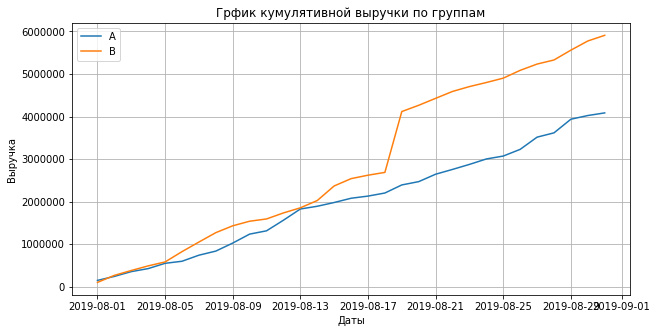

In [19]:
# строим графики выручки групп А и В

plt.figure(figsize=(10,5))
plt.plot(cumRevA['date'], cumRevA['revenue'], label = 'A')
plt.plot(cumRevB['date'], cumRevB['revenue'], label = 'B')
plt.grid()
plt.xlabel('Даты')
plt.ylabel('Выручка')
plt.title('Грфик кумулятивной выручки по группам')
plt.legend()
plt.show()

In [20]:
# проверяем период "скочка" для группы В,
# оцениваем изменения по дням относительно предыдущего

cumRevB_jump = cumRevB[cumRevB['date'].between('2019-08-17', '2019-08-21')].reset_index()

cumRevB_jump['rev_growth'] = cumRevB_jump.iloc[:, 2].div(cumRevB_jump.iloc[:, 2].shift())
cumRevB_jump['orders_growth'] = cumRevB_jump.iloc[:, 3].div(cumRevB_jump.iloc[:, 3].shift())

display(cumRevB_jump)

,index,date,revenue,orders,rev_growth,orders_growth
0,33,2019-08-17,2620790,373,NaN,NaN
1,35,2019-08-18,2686621,382,1.025119,1.024129
2,37,2019-08-19,4116541,403,1.532237,1.054974
3,39,2019-08-20,4263815,423,1.035776,1.049628
4,41,2019-08-21,4426892,437,1.038247,1.033097


**ВЫВОДЫ ПО ГРАФИКУ И РАСЧЕТАМ:**

Выручка в обеих группах увеличивается в течении всего теста.

* На начальном этапе выручки совпадают. Затем выручка  тестовой группы В подрастает относительно контрольной группы и к концу первой половины теста они опять встречаются на отметке в районе 1 800 000 рублей.
* В начале второй половины теста происходит скачек в выручке группы В на уровень 4 000 000 рублей, тогда как рост контрольной группы происходит равномерно.
* Скачек в выручке группы В происходит 19 августа на 53% относительно предыдущего дня. До 19 августа и после развитие кумулятивной выручки в группе В происходит равномерно. При этом количество заказов развивается достаточно планомерно.
* После скачка развитие кумулятивной выручки в группах А и В идет опять параллельными курсами по возврастающей. К концу теста контрольная группа приближается к отметке 4 000 000 руб., тестовая - 6 000 000.

### Анализ кумулятивного среднего чека по группам

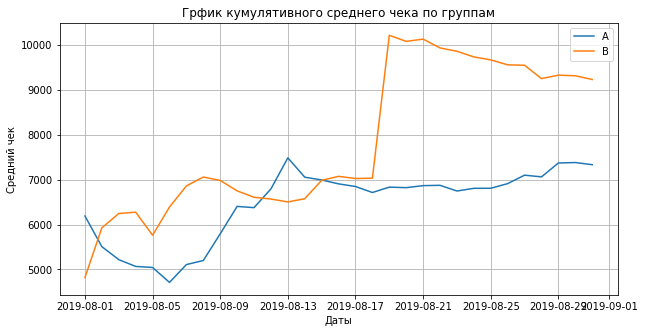

In [21]:
plt.figure(figsize=(10,5))
plt.plot(cumRevA['date'], cumRevA['revenue'] / cumRevA['orders'], label = 'A')
plt.plot(cumRevB['date'], cumRevB['revenue'] / cumRevB['orders'], label = 'B')
plt.grid()
plt.xlabel('Даты')
plt.ylabel('Средний чек')
plt.title('Грфик кумулятивного среднего чека по группам')
plt.legend()
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* Контрольная группа А начинает тест с падения среднего чека с уровня 6 100 руб до уровня 4 500 руб. В начале второй четверти динамика меняется на рост. В середине теста с отметки 7 500 руб начиается выравнивание.

* Динамика среднего чека тестовой группы В начинается с отметки 4 500 руб в начале теста с дальнейшим ростом до уровня 7 000. В середине теста происходит резкий скачек с 7 до 10 000 с последующим спадом, продолжающимся и в конце теста.

* Скачек в середине теста может быть вызван аномальной для магазина покупкой. Он очевидно повлиял на динамику кумулятивной выручки.

### Анализ относительного изменения кумулятивного среднего чека группы B к группе A

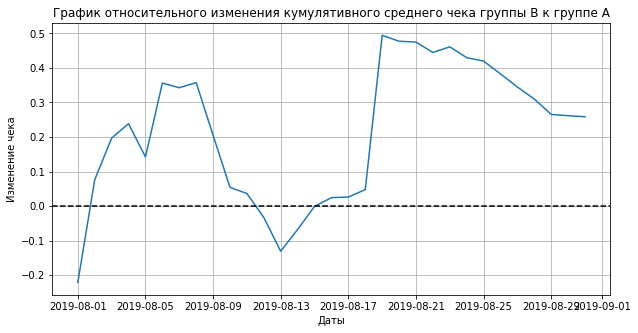

In [22]:
# объединяем данные в одном датафрейме,
# строим отношение средних чеков

mergedCumRev = cumRevA.merge(cumRevB, left_on = 'date', right_on = 'date', how = 'left', suffixes = ['A', 'B'])
plt.figure(figsize=(10,5))
plt.plot(mergedCumRev['date'],
         (mergedCumRev['revenueB'] / mergedCumRev['ordersB']) / (mergedCumRev['revenueA'] / mergedCumRev['ordersA']) - 1)
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.grid()
plt.xlabel('Даты')
plt.ylabel('Изменение чека')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* график относительного изменения кумулятивного среднего чека группы B к группе A показывает, что за период теста 3 раза чеки совпадали
* В начале проекта чек тестовой группы был ниже контройльной
* К концу второй четверти проекта чек контрольной группы превысил чек тестовой
* В середине проекта в тестовой группе произошел практически двукратный скачек относительно чека контрольной
* После скачка разница стала медленно, но верно сокращаться
* В последние несколько дней теста разница выровнялась, но нельзя с уверенностью сказать, что это выход на плато. В случае продолжения теста, есть вероятность , что снижение может продолжиться


### Анализ кумулятивной конверсии по группам

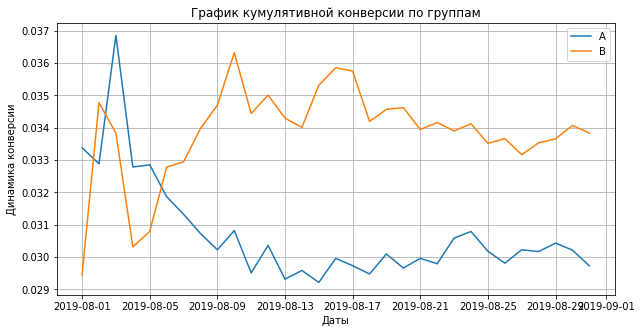

In [23]:
# считаем кумулятивную конверсию,
# отделяем данные по группам А и В,
# строим графики

cumData['conversion'] = cumData['orders'] / cumData['visitors']
cumDataA = cumData[cumData['group'] == 'A']
cumDataB = cumData[cumData['group'] == 'B']

plt.figure(figsize=(10,5))
plt.plot(cumDataA['date'], cumDataA['conversion'], label = 'A')
plt.plot(cumDataB['date'], cumDataB['conversion'], label = 'B')
plt.grid()
plt.xlabel('Даты')
plt.ylabel('Динамика конверсии')
plt.title('График кумулятивной конверсии по группам')
plt.legend()
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* Конверсии контрольной и тестовой групп имеют различный старт. Конверсия контрольной группы А входит в тест с существенно бульшим показателем 3,35%, тогда как группа В стартует с показателем конверсии 2,95%
* В первые дни в обеих группах происходит скачек, после которого конверсия контрольной группы А начинает снижение с пика в 3,7% до уровня 3%, вдоль которого продолжает незначительные колебания до конца теста и практически выравнивается
* Конверсия тестовой группы проваливается после первого скочка, но затем берет тренд на рост и начинает колебания в районе 3,4%
* К концу теста обе кривые идут на спад

### Анализ относительного изменения кумулятивной конверсии группы B к группе A

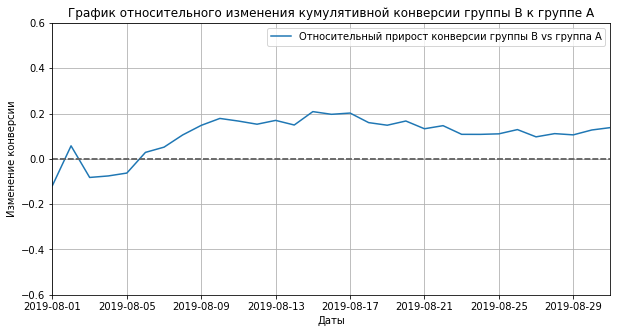

In [24]:
# объединяем данные в одном датафрейме,
# строим отношение кумулятивных конверсий групп

mergedCumConv = cumDataA[['date', 'conversion']].merge(
    cumDataB[['date', 'conversion']], left_on = 'date', right_on = 'date', how = 'left', suffixes = ['A', 'B'])

plt.figure(figsize=(10,5))
plt.plot(mergedCumConv['date'],
        mergedCumConv['conversionB'] / mergedCumConv['conversionA'] - 1,
         label = 'Относительный прирост конверсии группы В vs группа А')
plt.legend()
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.axhline(y = 0, color = 'grey', linestyle = '--')
plt.axis(['2019-08-01', '2019-08-31', -0.6, 0.6])
plt.grid()
plt.xlabel('Даты')
plt.ylabel('Изменение конверсии')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.show()

**ВЫВОДЫ ПО ГРАФИКУ:**

* В начале теста конверсии групп боролись за лидерство с переменным успехом
* В начале второй четверти конверсия тестовой группы стала стабильно превышать конверсию контрольной
* В этот же период начинается лидерство тестовой группы по выручке, динамика метрик коррелирует

### Анализ количества заказов по пользователям

In [25]:
# создаем таблицу для расчета кол-ва заказов по пользователям

ordersByUsers = (orders.groupby('visitorId', as_index = False).agg({'transactionId': pd.Series.nunique}))
ordersByUsers.columns = ['userid', 'orders']
display(ordersByUsers.sort_values(by = 'orders', ascending=False).head(10))

,userid,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


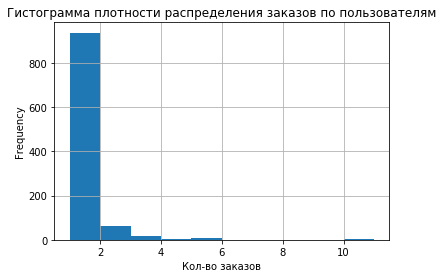

In [26]:
# строим гистограмму плотности распределения заказов по пользователям

ordersByUsers['orders'].plot(kind='hist', bins=10, title='Гистограмма плотности распределения заказов по пользователям')
plt.grid()
plt.xlabel('Кол-во заказов')
plt.show()

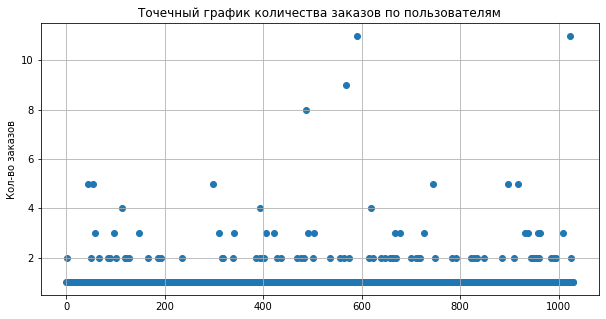

In [27]:
# строим точечную диагармму распределения кол-ва заказов на одного пользователя

plt.figure(figsize=(10,5))
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.grid()
plt.ylabel('Кол-во заказов')
plt.title('Точечный график количества заказов по пользователям')
plt.show()

**ВЫВОДЫ ПО ТАБЛИЦЕ И ГРАФИКАМ:**

* Большинство пользователей сделали от 1 до 2 заказов за период теста (01.08.2019 - 31.08.2019)
* Есть единичный случай оформления 8 заказов, единичный случай - 9 заказов и 2 случая оформления по 11 заказов

**Расчет 95-го и 99-го перцентилей количества заказов на пользователя**

In [28]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


**ВЫВОДЫ ПО РАСЧЕТАМ:**

* 99% пользователей сделали за тестовый период до 4 заказов включительно



**Проверяем заказы ТОП 3-х пользователей по количеству**

In [29]:
display(orders.query('visitorId == 4256040402').sort_values(by='date', ascending=True))

,transactionId,visitorId,date,revenue,group
114,1120327437,4256040402,2019-08-01,5800,A
873,2519737434,4256040402,2019-08-08,58220,B
1091,750632879,4256040402,2019-08-12,50,A
60,1421016313,4256040402,2019-08-16,56650,B
187,2048878902,4256040402,2019-08-17,1550,A
263,2575861846,4256040402,2019-08-18,10970,B
588,3700356838,4256040402,2019-08-20,17650,A
253,1610091760,4256040402,2019-08-23,16950,A
901,3402467119,4256040402,2019-08-27,1630,A
1018,1415970216,4256040402,2019-08-31,5170,A


In [30]:
display(orders.query('visitorId == 2458001652').sort_values(by='date', ascending=True))

,transactionId,visitorId,date,revenue,group
611,1244084011,2458001652,2019-08-04,340,A
883,2412219836,2458001652,2019-08-05,2420,B
454,3755354294,2458001652,2019-08-06,7349,B
456,543654048,2458001652,2019-08-06,1620,A
483,2280027650,2458001652,2019-08-06,6681,B
727,3959083601,2458001652,2019-08-07,17379,A
916,527333943,2458001652,2019-08-08,5227,B
692,3586870909,2458001652,2019-08-09,5227,B
1062,1817215137,2458001652,2019-08-11,8280,A
133,3060563671,2458001652,2019-08-22,5190,A


In [31]:
display(orders.query('visitorId == 2378935119').sort_values(by='date', ascending=True))

,transactionId,visitorId,date,revenue,group
697,1612868255,2378935119,2019-08-09,30649,B
1029,469609643,2378935119,2019-08-10,58220,A
1031,1661772358,2378935119,2019-08-10,2640,B
33,486237576,2378935119,2019-08-15,1650,A
179,1784270968,2378935119,2019-08-17,310,A
118,4233533907,2378935119,2019-08-22,3390,A
391,2213813903,2378935119,2019-08-25,21220,B
435,2430683444,2378935119,2019-08-28,20450,B
473,3224706027,2378935119,2019-08-28,4410,B


**ВЫВОДЫ ПО ПРОВЕРКЕ:**

* поведение пользователей, сделавших самое большое количество покупок выглядит вполне адекватным:
>
> покупки происходят регулярно с первых до последних дней теста
>
> у всех 3-х пользователей есть дни, в которые они делали 2 - 3 заказа; можно предположить, что один из этих заказов является основным, а остальные вспомогательными, когда пользователь "забыл что-то положить в корзину"

* Проблемой является то, что эти пользователи мигрируют между группами и будут исключены при очистке данных

### Анализ стоимостей заказов

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64


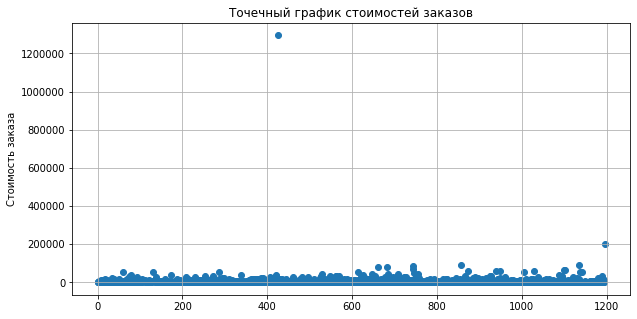

In [32]:
# выводим стат данные о заказах по выручке
# строим точечную диаграмму

print(orders['revenue'].describe())

plt.figure(figsize=(10,5))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.grid()
plt.ylabel('Стоимость заказа')
plt.title('Точечный график стоимостей заказов')
plt.show()

In [33]:
# выводим информацию об аномальном заказе

display(orders.query('revenue >= 1294500'))

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B


In [34]:
# выводим информацию о заказах пользователя,
# сделавшего аномальный заказ

display(orders.query('visitorId == 1920142716').sort_values(by='date', ascending=True))

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B


**ВЫВОДЫ ПО ГРАФИКУ И ТАБЛИЦАМ:**

* минимальный заказ равен 50 рублям
* среднее значение равно 8 348 рублей
* медиана равна 2 978 руб
* 75% заказов находятся в диапазоне до 8 290 руб
* имеется 1 аномальный заказ на сумму 1 294 500 руб, который существенно влияет на статистику
* аномальный заказ был сделан 19.08.2019 пользователем из группы В и является единственным заказом этого пользователя в тестовый период
* аномальный заказ повлиял на поведение выручки и среднего чека группы В в рамках теста

**Расчет 95-го и 99-го перцентилей стоимости заказов**

In [35]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


**ВЫВОДЫ ПО РАСЧЕТАМ:**

* 99% заказов имеют стоимость в диапазоне до 58 233 руб
* Границу аномальных заказов предлагается установить на уровне 99 перцентиля

### Расчет стат значимости различий в конверсии м/у группами по «сырым» данным

#### Подготовка данных

In [36]:
# подготавливаем данные по группе А - пользователи:
# кол-во пользоватлей в день, кумулятивное кол-во пользователей

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACum = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]\
                                    .agg({'date':'max', 'visitorsPerDateA':'sum'}), axis = 1)
visitorsACum.columns = ['date', 'visitorsCumA']

# подготавливаем данные по группе B - пользователи:
# кол-во пользоватлей в день, кумулятивное кол-во пользователей

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCum = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]\
                                    .agg({'date':'max', 'visitorsPerDateB':'sum'}), axis = 1)
visitorsBCum.columns = ['date', 'visitorsCumB']

In [37]:
# подготавливаем данные по группе А - заказы:
# кол-во заказов и сумма выручки в день

ordersADaily = orders[orders['group'] == 'A'][['date', 'transactionId','visitorId', 'revenue']]\
                .groupby('date', as_index = False).agg({'transactionId' : pd.Series.nunique, 'revenue':'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACum = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']]\
                                .agg({'date':'max', 'ordersPerDateA':'sum', 'revenuePerDateA':'sum'}), axis = 1)\
                                .sort_values(by=['date'])

ordersACum.columns = ['date', 'ordersCumA', 'revenueCumA']

# подготавливаем данные по группе B - заказы:
# кол-во заказов и сумма выручки в день

ordersBDaily = orders[orders['group'] == 'B'][['date', 'transactionId','visitorId', 'revenue']]\
                .groupby('date', as_index = False).agg({'transactionId' : pd.Series.nunique, 'revenue':'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCum = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]\
                                .agg({'date':'max', 'ordersPerDateB':'sum', 'revenuePerDateB':'sum'}), axis = 1)\
                                .sort_values(by=['date'])

ordersBCum.columns = ['date', 'ordersCumB', 'revenueCumB']

In [38]:
# сводим подготовленные данные по группам в единую таблицу

data = (
    ordersADaily.merge(
        ordersBDaily, left_on = 'date', right_on = 'date', how = 'left'
    )
       .merge(ordersACum, left_on = 'date',right_on = 'date', how = 'left')
       .merge(ordersBCum, left_on = 'date',right_on = 'date', how = 'left')
       .merge(visitorsADaily, left_on = 'date', right_on = 'date', how = 'left')
       .merge(visitorsBDaily, left_on = 'date', right_on = 'date', how = 'left')
       .merge(visitorsACum, left_on = 'date', right_on = 'date', how = 'left')
       .merge(visitorsBCum, left_on = 'date', right_on = 'date', how = 'left')
)
display(data.sample(5))

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCumA,revenueCumA,ordersCumB,revenueCumB,visitorsPerDateA,visitorsPerDateB,visitorsCumA,visitorsCumB
20,2019-08-21,23,174309,14,163077,385,2643838,437,4426892,646,656,12850,12874
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
10,2019-08-11,13,77585,13,53310,206,1313683,241,1592513,718,721,6980,6998
11,2019-08-12,24,249190,23,141554,230,1562873,264,1734067,595,543,7575,7541
16,2019-08-17,10,50861,14,81155,311,2129769,373,2620790,412,421,10459,10434


In [39]:
# рассчитываем число заказов на каждого пользователя
# в группах А и В

ordersByUsersA = (
    orders[orders['group'] == 'A']
.groupby('visitorId', as_index = False)
.agg({'transactionId':pd.Series.nunique})
)
ordersByUsersA.columns = ['userid', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
.groupby('visitorId', as_index = False)
.agg({'transactionId':pd.Series.nunique})
)
ordersByUsersB.columns = ['userid', 'orders']

In [40]:
# создаем переменные для обозначения выборок групп А и В,
# в которых каждому пользователю соответствует кол-во заказов, включая "0"

sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, index=np.arange(data['visitorsPerDateA']\
                                                   .sum() - len(ordersByUsersA['orders'])),name = 'orders')],axis = 0)

sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0, index=np.arange(data['visitorsPerDateB']\
                                                    .sum() - len(ordersByUsersB['orders'])),name = 'orders')], axis = 0)

#### Проверка гипотезы о нормальности распределения данных в выборках для принятия решения о выборе метода определения стат значимости различий в конверсии между группами. Н0 = распределение нормально

In [41]:
# проверяем нормальность распределения выборки А методом
# Шапиро - Уилка

alpha = 0.05 # устанавливаем уровень критической значимости
results = st.shapiro(sampleA)
p_value = results[1]

print('p-значение:', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: распределение не нормально")
else:
        print("Не получилось отвергнуть нулевую гипотезу: распределение нормально")

p-значение: 0.0
Отвергаем нулевую гипотезу: распределение не нормально


/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [42]:
# проверяем нормальность распределения методом B
# Шапиро - Уилка

alpha = 0.05 # устанавливаем уровень критической значимости
results = st.shapiro(sampleB)
p_value = results[1]

print('p-значение:', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: распределение не нормально")
else:
        print("Не получилось отвергнуть нулевую гипотезу: распределение нормально")

p-значение: 0.0
Отвергаем нулевую гипотезу: распределение не нормально


**ВЫВОДЫ ПО ПРОВЕРКЕ ГИПОТЕЗЫ О НОРМАЛЬНОСТИ РАСПРЕДЕЛЕНИЯ В ВЫБОРКАХ:**

Проверка выборок контрольной и тестовой групп методом Шапиро - Уилка показала, что вычесленное значение р в обеих группах стремится к 0, т.е. значительно меньше установленного уровня критической значимости, равного 0,05. Данный факт позволяет отклонить нулевую гипотезу о нормальности распределения данных в выборках. Для определения стат значимости различий в конверсии между группами будет использован непармаетрический метод Манна - Уитни.

#### Проверка гипотезы об отсутствии статистически значимых различий в конверсии между группами. Н0 = различия отсутствуют

**В рамках сформулированной гипотезы об отсутствии различий применяем параметр двустороннего теста 'alternative="two-sided"'**

In [43]:
# в связи с ненормальностью распределения применяем непараметрический метод
# Манна - Уитни для определения стат значимости различий в конверсии м/у группами по «сырым» данным
# выводим относительный прирост конверсии группы В

alpha = 0.05 # устанавливаем уровень критической значимости

print('{0:.3f}'.format(st.mannwhitneyu(sampleA, sampleB, alternative="two-sided")[1]))
print()
print('{0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

0.017

0.138


**ВЫВОДЫ ПО РАСЧЕТАМ:**

По "сырым" данным различия в конверсии между группами А и В существуют. Значение p-value, полученное в результате двустороннего теста методом Манна - Уитни, составило 0,017, что меньше уровня критической значимости 0,05, что позволяет отвергнуть нулевую гипотезу об отсутствии статистически значимых различий в конверсии между группами. Относительное преимущество группы В в конверсии составило 13,8%.

### Расчет стат значимости различий в среднем чеке заказа м/у группами по «сырым» данным. Проверка гипотезы об отсутствии различий. Н0 = различия отсутствуют

**В рамках сформулированной гипотезы об отсутствии различий применяем параметр двустороннего теста 'alternative="two-sided"'**

In [44]:
# применяем непараметрический метод Манна - Уитни для расчета
# стат значимости различий в среднем чеке заказа м/у группами по «сырым» данным
# выводим относительный прирост чека группы В

alpha = 0.05 # устанавливаем уровень критической значимости


print('{0:.3f}'.format(st.mannwhitneyu(orders[orders['group'] == 'A']['revenue'],orders[orders['group'] == 'B']\
                                       ['revenue'], alternative="two-sided")[1]))
print()
print('{0:.3f}'.format(orders[orders['group'] == 'B']['revenue'].mean() / orders[orders['group'] == 'A']['revenue'].mean() - 1))

0.729

0.259


**ВЫВОДЫ ПО РАСЧЕТАМ:**

По "сырым" данным различия в среднем чеке между группами А и В отсутствуют. Значение p-value, полученное в результате теста методом Манна - Уитни, составило 0,729, что значительно больше уровня критической значимости 0,05, что позволяет принять нулевую гипотезу об отсутствии статистически значимых различий в среднем чеке между группами. Хотя среднеий чек группы В ниже среднего чека группы А.

### Расчет стат значимости различий в конверсии м/у группами по «очищенным» данным

#### очистка данных от пользователей со смешанным трафиком

In [45]:
# формируем данные, исключающие пользователей, проявивших смешанное поведение

orders_split_pure = orders_split[orders_split['group_mix'] == 'pure']

orders_pure = orders[orders['visitorId'].isin(orders_split_pure['visitorId'])]

In [46]:
# проверяем распределение по данным, очищенным от смешенного трафика

display(orders_pure.sort_values(by='date', ascending=True).groupby('group').agg({'group':'first', 'visitorId':'nunique'}))

,group,visitorId
group,,
A,A,445
B,B,528


count    1.016000e+03
mean     8.300815e+03
std      4.212199e+04
min      5.000000e+01
25%      1.190000e+03
50%      2.955000e+03
75%      8.134250e+03
max      1.294500e+06
Name: revenue, dtype: float64


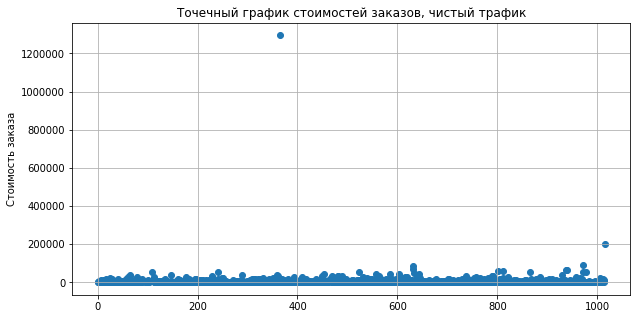

In [47]:
# выводим стат данные о заказах по выручке на основе данных, очищенных от смешанного трафика
# строим точечную диаграмму

print(orders_pure['revenue'].describe())

plt.figure(figsize=(10,5))
x_values = pd.Series(range(0,len(orders_pure['revenue'])))
plt.scatter(x_values, orders_pure['revenue'])
plt.grid()
plt.ylabel('Стоимость заказа')
plt.title('Точечный график стоимостей заказов, чистый трафик')
plt.show()

In [48]:
# рассчитываем 95 и 99 перцентиль по данным о выручке с чистым трафиком

print(np.percentile(orders_pure['revenue'], [95, 99]))

[26785. 53904.]


**ВЫВОДЫ ПО ОЧИСТКЕ ДАННЫХ ОТ СМЕШАННОГО ТРАФИКА:**

В результате очистки данных от смешанного трафика из расчетов выбыло 58 пользователей. Распределение между группами осталось неравномерным:
* группа А = 445 пользователей
* группа В = 528 пользователей

Средние параметры выручки изменились в меньшую сторону:
* среднее - было 8 348 / стало 8 300
* медиана - было 2 978 / стало 2 955
* максимальное значение осталось неизменным - 1 294 500
* 95-й перцентиль - было 28 000 / стало 26 785
* 99-й перцентиль - было 58 233 / стало 53 904

#### очистка данных от аномальных заказов стоимостью выше 99 персентиля

In [49]:
# отфильтровываем обновленные данные по 99-му перцентилю
# выводим стат информацию о выручке

orders_pure_clean_rev = orders_pure[orders_pure['revenue'] <= 54000]
display(orders_pure_clean_rev['revenue'].describe())

count     1007.000000
mean      6393.414101
std       8714.198006
min         50.000000
25%       1190.000000
50%       2938.000000
75%       7990.000000
max      53904.000000
Name: revenue, dtype: float64

In [50]:
# производим перерасчет числа заказов на каждого пользователя
# в группах А и В

ordersByUsersA_pure_clean_rev = (
    orders_pure_clean_rev[orders_pure_clean_rev['group'] == 'A']
.groupby('visitorId', as_index = False)
.agg({'transactionId':pd.Series.nunique})
)
ordersByUsersA_pure_clean_rev.columns = ['userid', 'orders']

ordersByUsersB_pure_clean_rev = (
    orders_pure_clean_rev[orders_pure_clean_rev['group'] == 'B']
.groupby('visitorId', as_index = False)
.agg({'transactionId':pd.Series.nunique})
)
ordersByUsersB_pure_clean_rev.columns = ['userid', 'orders']

In [51]:
# создаем переменные для обозначения выборок групп А и В c чистым разделением трафика,
# в которых каждому пользователю соответствует кол-во заказов, включая "0"

sampleA_pure_clean_rev = pd.concat([ordersByUsersA_pure_clean_rev['orders']\
                                    ,pd.Series(0, index=np.arange(data['visitorsPerDateA']\
                                    .sum() - len(ordersByUsersA_pure_clean_rev['orders']))\
                                    ,name = 'orders')],axis = 0)

sampleB_pure_clean_rev = pd.concat([ordersByUsersB_pure_clean_rev['orders']\
                                    ,pd.Series(0, index=np.arange(data['visitorsPerDateB']\
                                    .sum() - len(ordersByUsersB_pure_clean_rev['orders']))\
                                    ,name = 'orders')], axis = 0)

#### Проверка гипотезы об отсутствии статистически значимых различий в конверсии между группами по "очищенным" данным. Н0 = различия отсутствуют

**В рамках сформулированной гипотезы об отсутствии различий применяем параметр двустороннего теста 'alternative="two-sided"'**

In [52]:
# применяем непараметрический метод Манна - Уитни
# для определения стат значимости различий в конверсии м/у группами по «очищенным» данным
# выводим относительный прирост конверсии группы В

alpha = 0.05 # устанавливаем уровень критической значимости

print('{0:.3f}'.format(st.mannwhitneyu(sampleA_pure_clean_rev, sampleB_pure_clean_rev, alternative="two-sided")[1]))
print()
print('{0:.3f}'.format(sampleB_pure_clean_rev.mean() / sampleA_pure_clean_rev.mean() - 1))

0.010

0.164


**ВЫВОДЫ ПО РАСЧЕТАМ:**

По "очищенным" данным различия в конверсии между группами А и В существуют. Значение p-value, полученное в результате теста методом Манна - Уитни, составило 0,010, что меньше уровня критической значимости 0,05, что позволяет отвергнуть нулевую гипотезу об отсутствии статистически значимых различий в конверсии между группами. Относительное преимущество группы В в конверсии составило 16,4%.

### Расчет стат значимости различий в среднем чеке заказа м/у группами по «очищенным» данным/ Проверка гипотезы об отсутствии различий. Н0 = различия отсутствуют

**В рамках сформулированной гипотезы об отсутствии различий применяем параметр двустороннего теста 'alternative="two-sided"'**

In [53]:
# применяем непараметрический метод Манна - Уитни для расчета
# стат значимости различий в среднем чеке заказа м/у группами по «очищенным» данным
# выводим относительный прирост чека группы В

print('{0:.3f}'.format(st.mannwhitneyu(orders_pure_clean_rev[orders_pure_clean_rev['group'] == 'A']['revenue'],
                                      orders_pure_clean_rev[orders_pure_clean_rev['group'] == 'B']['revenue']\
                                      , alternative="two-sided")[1]))
print()
print('{0:.3f}'.format(orders_pure_clean_rev[orders_pure_clean_rev['group'] == 'B']['revenue'].mean()\
                       / orders_pure_clean_rev[orders_pure_clean_rev['group'] == 'A']['revenue'].mean() - 1))

0.901

-0.032


**ВЫВОДЫ ПО РАСЧЕТАМ:**

По "очищенным" данным различия в среднем чеке между группами А и В отсутствуют. Значение p-value, полученное в результате теста методом Манна - Уитни, составило 0,901, что значительно больше уровня критической значимости 0,05, что позволяет принять нулевую гипотезу об отсутствии статистически значимых различий в среднем чеке между группами. Хотя среднеий чек группы В ниже среднего чека группы А.

## Решение по результатам теста

1. Остановить тест, зафиксировать победу одной из групп
2. Остановить тест, зафиксировать отсутствие различий между группами
3. Продолжить тест

Тест проводился в период с 01.08.2019 по 31.08.2019.

**Анализ распределения пользователей** по группам показал 2 ошибки в дизайне и организации теста:
> кол-во пользователей в группах не совпадало - А (контрольная группа) = 503 пользователя, В (тестовая группа) = 586 пользователей
>
> 58 (или 6%) пользователей проявили смешанное поведение (попали в обе группы при фиксации результатов)

Количественно выборки позволили произвести очистку данных, проигнорировать неравномерное распределение и продолжить анализ. Рекомендация отделу маркетинга произвести анализ причин ошибок неравномерности распределения пользователей по группам, а также деления трафика и исключить их возможность для будущих тестов.

По результатам теста была проведена **проверка 2-х гипотез**:
> 
> "об отсутствии статистически значимых различий в конверсии между контрольной и тестовой группами"
>
> "об отсутствии статистически значимых различий в среднем чеке заказа между контрольной и тестовой группами"

Проверка производилась как на "сырых", так и на "очищенных" (за исключением пользователей со смешанным поведением и одного заказа с аномальной стоимостью) данных. Для оценки стат значимости был использован двусторонний непараметрический тест Манна - Уитни. Оба набора данных показали одинаковый результат:
>
> **Подтвердилась** статистическая значимость различий **в конверсии**
>
> **НЕ подтвердилась** статистическая значимость различий **в среднем чеке**

Анализ кумулятивной конверсии по группам и относительного изменения кумулятивной конверсии группы В к группе А подтверждают и иллюстрируют наличие различий.

Анализ кумулятивного среднего чека по группам и относительного изменения среднего чека группы В к группе А показывает близость значений, что усиливается после очистки данных от аномального чека от 19.08.2019 на сумму 1 294 500 рублей, вызвашего "скочек" данных в группе В по выручке и среднему чеку.

Предлагается остановить тест и зафиксировать победу тестовой группы В с точки зрения улучшения конверсии при неизменном среднем чеке относительно контрольной группы А.